# XGBoost Time Series Forecasting

Based on:
* [Time Series Forecasting on Stock Prices](https://www.youtube.com/watch?v=j05UUs99eNQ) from [Coding Tech](https://www.youtube.com/channel/UCtxCXg-UvSnTKPOzLH4wJaQ)
* https://machinelearningmastery.com/xgboost-for-time-series-forecasting/

**Disclaimer:** _Investing in the stock market involves risk and can lead to monetary loss. This material is purely for educational purposes and should not be taken as professional investment advice. Invest at your own discretion._

In [1]:
# ! pip3 install xgboost

In [2]:
import pandas as pd

from numpy import asarray

from sklearn.metrics import mean_absolute_error

from xgboost import XGBRFRegressor

from matplotlib import pyplot

Transform a time series dataset to a supervised learning dataset

In [3]:
# Transform a time series dataset to a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols = list()
    # Input sequence (t-n ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # Forecast sequence (t, t+1 ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # Put it all together
    agg = pd.concat(cols, axis=1)
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values

Split a univariate dataset into train/test sets

In [4]:
def train_test_split(data, n_test):
    return data[:-n_test, :], data[-n_test:, :]

Fit an XGBoost model and make a one step prediction

In [5]:
def xgboost_forecats(train, testX):
    # Transform list into array
    train = asarray(train)
    # Split into input and output columns
    trainX, trainy = train[:, :-1], train[:, -1]
    # Fit model
    model = XGBRFRegressor(objective='reg:squarederror', n_estimators=1000)
    model.fit(trainX, trainy)
    # Make a one step prediction
    yhat = model.predict(asarray([testX]))
    return yhat[0]

Walk-forward validation for univariate data

In [6]:
def walk_forward_validation(data, n_test):
    predictions = list()
    # Split dataset
    train, test = train_test_split(data, n_test)
    # Seed history with training dataset
    history = [x for x in train]
    # Step over each time step in the test set
    for i in range(len(test)):
        # Split test row into input and output columns
        testX, testy = test[i, :-1], test[i, -1]
        # Fit model on history and make a prediction
        yhat = xgboost_forecats(history, testX)
        # Store forecast in list of predictions
        predictions.append(yhat)
        # Add actual observation to history for the next loop
        history.append(test[i])
        # Summarize progress
        print(f'>expected={testy}, predicted={yhat}')
    # Estimate prediction error
    error = mean_absolute_error(test[:, -1], predictions)
    return error, test[:, -1], predictions

Load the data

In [7]:
df = pd.read_csv("SP500.csv")

Show the data

In [8]:
df

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2000-05-19,96.106028,96.106028,94.484962,94.779701,775500,0.0,0
1,2000-05-22,94.716551,94.716551,92.169162,94.190231,1850600,0.0,0
2,2000-05-23,94.463952,94.463952,92.758675,92.758675,373900,0.0,0
3,2000-05-24,92.800753,94.358660,92.063905,94.148132,400300,0.0,0
4,2000-05-25,94.337613,94.948145,92.884970,93.284973,69600,0.0,0
...,...,...,...,...,...,...,...,...
5359,2021-09-08,452.899994,453.679993,450.869995,453.000000,4076800,0.0,0
5360,2021-09-09,452.690002,454.579987,450.730011,450.980011,3851600,0.0,0
5361,2021-09-10,453.059998,453.510010,447.299988,447.540009,3023500,0.0,0
5362,2021-09-13,450.679993,450.929993,446.089996,448.579987,3007400,0.0,0


Add indices for every day in the period

In [9]:
start_date = df.Date.min()
end_date = df.Date.max()

In [10]:
df_date = pd.date_range(start=start_date, end=end_date).to_frame(name="Date")
df_date.reset_index(drop=True, inplace=True) 

In [11]:
df["Date"] = pd.to_datetime(df["Date"])
df = df.merge(df_date, how='right')

Interpolate missing values

In [12]:
df = df.interpolate(method='linear', limit_direction='both')
df

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2000-05-19,96.106028,96.106028,94.484962,94.779701,7.755000e+05,0.0,0.0
1,2000-05-20,95.642869,95.642869,93.713029,94.583211,1.133867e+06,0.0,0.0
2,2000-05-21,95.179710,95.179710,92.941096,94.386721,1.492233e+06,0.0,0.0
3,2000-05-22,94.716551,94.716551,92.169162,94.190231,1.850600e+06,0.0,0.0
4,2000-05-23,94.463952,94.463952,92.758675,92.758675,3.739000e+05,0.0,0.0
...,...,...,...,...,...,...,...,...
7784,2021-09-10,453.059998,453.510010,447.299988,447.540009,3.023500e+06,0.0,0.0
7785,2021-09-11,452.266663,452.650004,446.896657,447.886668,3.018133e+06,0.0,0.0
7786,2021-09-12,451.473328,451.789998,446.493327,448.233327,3.012767e+06,0.0,0.0
7787,2021-09-13,450.679993,450.929993,446.089996,448.579987,3.007400e+06,0.0,0.0


Transform the time series data into supervised learning

In [13]:
prev_values = 10

In [14]:
data = series_to_supervised(df['Close'].values.tolist(), n_in=prev_values)

Evaluate

In [15]:
mae, y, yhat = walk_forward_validation(data, 10*prev_values)
print(f'MAE: {mae}')

/home/vladiant/.local/lib/python3.8/site-packages/xgboost/data.py:104: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


>expected=422.6531066894531, predicted=418.268798828125
>expected=422.6730346679688, predicted=418.4149169921875
>expected=421.9949951171875, predicted=418.5352478027344
>expected=424.0400085449219, predicted=418.6455383300781
>expected=424.739990234375, predicted=418.8302001953125
>expected=425.0799967447917, predicted=419.01995849609375
>expected=425.4200032552083, predicted=419.2989196777344
>expected=425.760009765625, predicted=419.56829833984375
>expected=424.9299926757813, predicted=419.91448974609375
>expected=422.5799865722656, predicted=420.23779296875
>expected=422.4500122070313, predicted=420.4589538574219
>expected=416.7699890136719, predicted=420.6348876953125
>expected=418.72999064127606, predicted=418.2846374511719
>expected=420.6899922688802, predicted=419.4186096191406
>expected=422.6499938964844, predicted=420.3532409667969
>expected=424.6600036621094, predicted=420.6769714355469
>expected=424.4100036621094, predicted=421.0256652832031
>expected=426.8699951171875, pre

Plot expected vs predicted

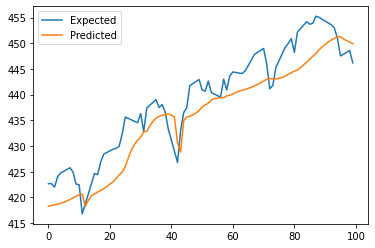

In [16]:
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.show()

## Predict a single value

Transform the time series data into supervised learning

In [17]:
train = series_to_supervised(df['Close'].values.tolist()[:-prev_values-1], n_in=prev_values)

 Split into input and output columns

In [18]:
trainX, trainy = train[:, :-1], train[:, -1]

Fit model

In [19]:
model = XGBRFRegressor(objective='reg:squarederror', n_estimators=1000)
model.fit(trainX, trainy)

XGBRFRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bytree=1, gamma=0, gpu_id=-1, importance_type='gain',
               interaction_constraints='', max_delta_step=0, max_depth=6,
               min_child_weight=1, missing=nan, monotone_constraints='()',
               n_estimators=1000, n_jobs=8, num_parallel_tree=1000,
               objective='reg:squarederror', random_state=0, reg_alpha=0,
               scale_pos_weight=1, tree_method='exact', validate_parameters=1,
               verbosity=None)

Construct an input for a new prediction

In [20]:
row = df['Close'].values.tolist()[-prev_values-1:-1]

Make a one step prediction

In [21]:
yhat = model.predict(asarray([row]))

In [22]:
print(f'Input: {row}')

Input: [454.702507019043, 454.3350067138672, 453.9675064086914, 453.6000061035156, 453.0, 450.9800109863281, 447.5400085449219, 447.8866678873698, 448.2333272298177, 448.5799865722656]


In [23]:
print(f'Predicted: {yhat[0]:.2f}, Expected: {df["Close"].values.tolist()[-1]:.2f}')

Predicted: 449.25, Expected: 446.19


**THIS IS NOT AN INVESTMENT ADVICE!**